In [2]:
CIDS = filter_othersegs(get_alllawyers())

In [3]:
df_test, start, end = get_test(CIDS)
df_control = get_control(start, end)
df_clients = pd.concat([df_test, df_control])
t, c = df_clients[df_clients.experimental==True], df_clients[df_clients.experimental==False]

In [4]:
df = get_data(df_clients)

In [5]:
#Remove all control data in a future date of which we would not be able to view test data right now
control_mindate = min(df[df.experimental==False].firstdayofimpressions)
test_mindate = min(df[df.experimental==True].firstdayofimpressions)
today = dt.date.today()
cutoff = control_mindate + dt.timedelta(days = (today - test_mindate).days)
mask = [x.experimental==False and x.day>cutoff for _, x in df.iterrows()]
df = df[~np.array(mask)]

df.groupby('experimental').agg({'adconfiguration_id': ['nunique'], 'firstdayofimpressions': ['min','max']})

adconfiguration_id firstdayofimpressions            
                        nunique                   min         max
experimental                                                     
False                       273            2016-01-28  2016-04-08
True                        266            2016-04-12  2016-06-24

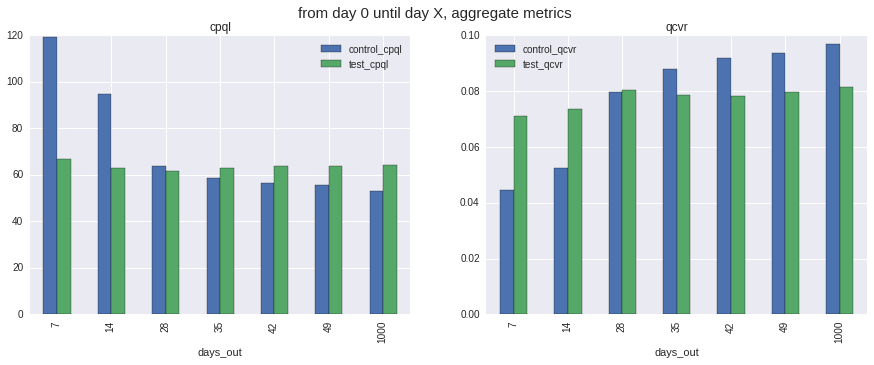

In [6]:
sns.set_style('darkgrid')

def days_out_quality_metrics(df, n):
    a = df[df.days_out<=n]
    a = a.groupby('experimental')['clicks', 'calls120', 'cost'].sum()
    
    return [n, 
            a.loc[True].cost / a.loc[True].calls120, 
            a.loc[True].calls120 / a.loc[True].clicks,
            a.loc[False].cost / a.loc[False].calls120, 
            a.loc[False].calls120 / a.loc[False].clicks
            ]

out_values = []
for d in [7, 14, 28, 35, 42, 49, 1000]:
    out_values.append(days_out_quality_metrics(df, d))
    
out = pd.DataFrame(out_values, columns=['days_out', 'test_cpql', 'test_qcvr', 'control_cpql', 'control_qcvr'])


_, axs = plt.subplots(1, 2, figsize=(15, 5))
_.suptitle('from day 0 until day X, aggregate metrics', fontsize=15)

out[['days_out', 'control_cpql', 'test_cpql']].set_index('days_out').plot(kind='bar', title='cpql', ax=axs[0])
out[['days_out', 'control_qcvr', 'test_qcvr']].set_index('days_out').plot(kind='bar', title='qcvr', ax=axs[1])

plt.show()

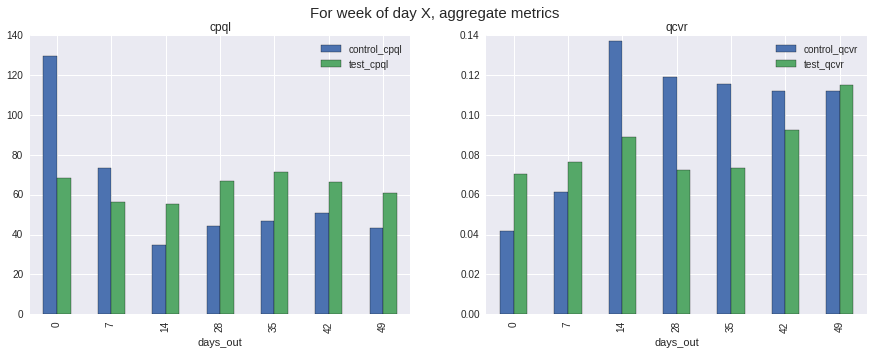

In [7]:
sns.set_style('darkgrid')

def days_out_quality_metrics(df, n):
    a = df[df.days_out>=n]
    a = a[a.days_out<(n+7)]
    a = a.groupby('experimental')['clicks', 'calls120', 'cost'].sum()
    
    return [n, 
            a.loc[True].cost / a.loc[True].calls120, 
            a.loc[True].calls120 / a.loc[True].clicks,
            a.loc[False].cost / a.loc[False].calls120, 
            a.loc[False].calls120 / a.loc[False].clicks
            ]

out_values = []
for d in [0, 7, 14, 28, 35, 42, 49]:
    out_values.append(days_out_quality_metrics(df, d))
    
out = pd.DataFrame(out_values, columns=['days_out', 'test_cpql', 'test_qcvr', 'control_cpql', 'control_qcvr'])


_, axs = plt.subplots(1, 2, figsize=(15, 5))
_.suptitle('For week of day X, aggregate metrics', fontsize=15)

out[['days_out', 'control_cpql', 'test_cpql']].set_index('days_out').plot(kind='bar', title='cpql', ax=axs[0])
out[['days_out', 'control_qcvr', 'test_qcvr']].set_index('days_out').plot(kind='bar', title='qcvr', ax=axs[1])

plt.show()

/home/acohen/miniconda3/envs/p3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


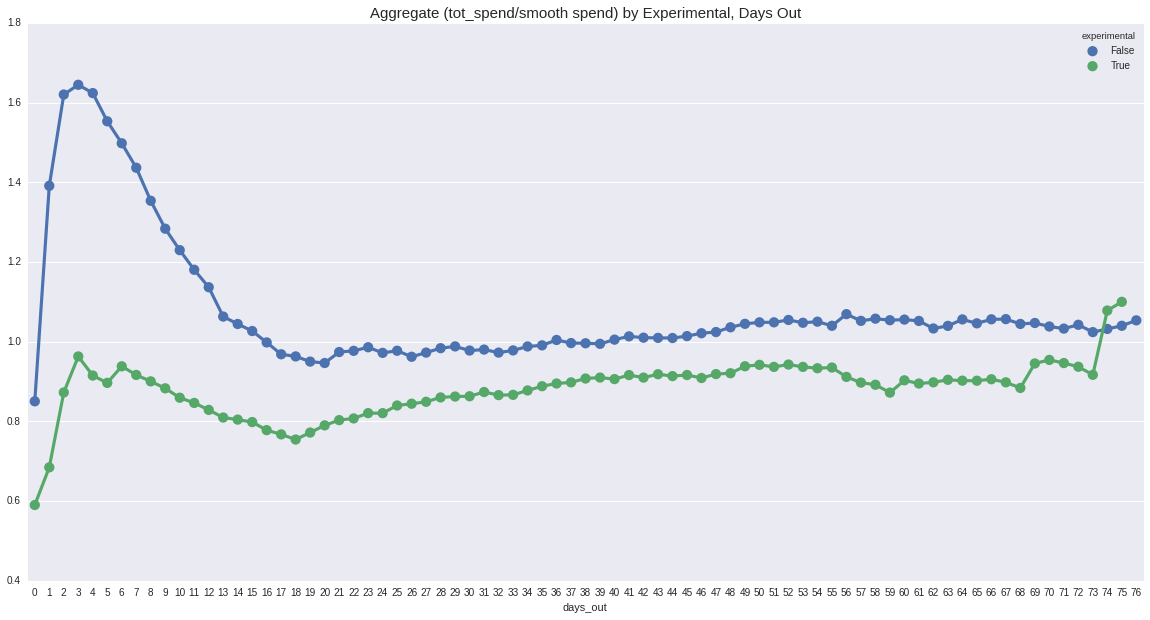

In [10]:
a = core('''select adconfiguration_id, budget, firstdayofimpressions, day, sum(margincost) as spend
        from analytics.client_static_basic a
         join control.provider_reports agg on a.client_id = agg.clientid
          and a.adconfiguration_id in {pACFIDS}
          join control.milestonedates mile on a.client_id = mile.client_id
          group by adconfiguration_id, budget, firstdayofimpressions, day'''.format(pACFIDS = tuple(set(df.adconfiguration_id))))

f = lambda x: (x.day - x.firstdayofimpressions).days
a['days_out'] = a.apply(f, axis=1)

a = pd.merge(a, df_clients[['adconfiguration_id', 'experimental']], on='adconfiguration_id')

mask = [x.experimental==False and x.day>cutoff for _, x in a.iterrows()]
a = a[~np.array(mask)]

a['smooth_spend'] = a.budget/30.4 * (a.days_out+1)

k = a.groupby(by=['adconfiguration_id', 'budget', 'days_out']).spend.sum().groupby(level=[0]).cumsum().reset_index(drop=False)
k = pd.merge(k, a[['adconfiguration_id', 'days_out', 'smooth_spend', 'experimental']], on=['adconfiguration_id', 'days_out'])

k = k.groupby(['experimental', 'days_out'], as_index=False)['spend', 'smooth_spend'].sum()
k['spend_ratio'] = k.spend / k.smooth_spend

_, axs = plt.subplots(1, 1, figsize=(20, 10))
sns.pointplot('days_out', 'spend_ratio', hue='experimental', data=k, ax=axs)
axs.set_title('Aggregate (tot_spend/smooth spend) by Experimental, Days Out', fontsize=15)
axs.set_ylabel('')
plt.show()

/home/acohen/miniconda3/envs/p3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


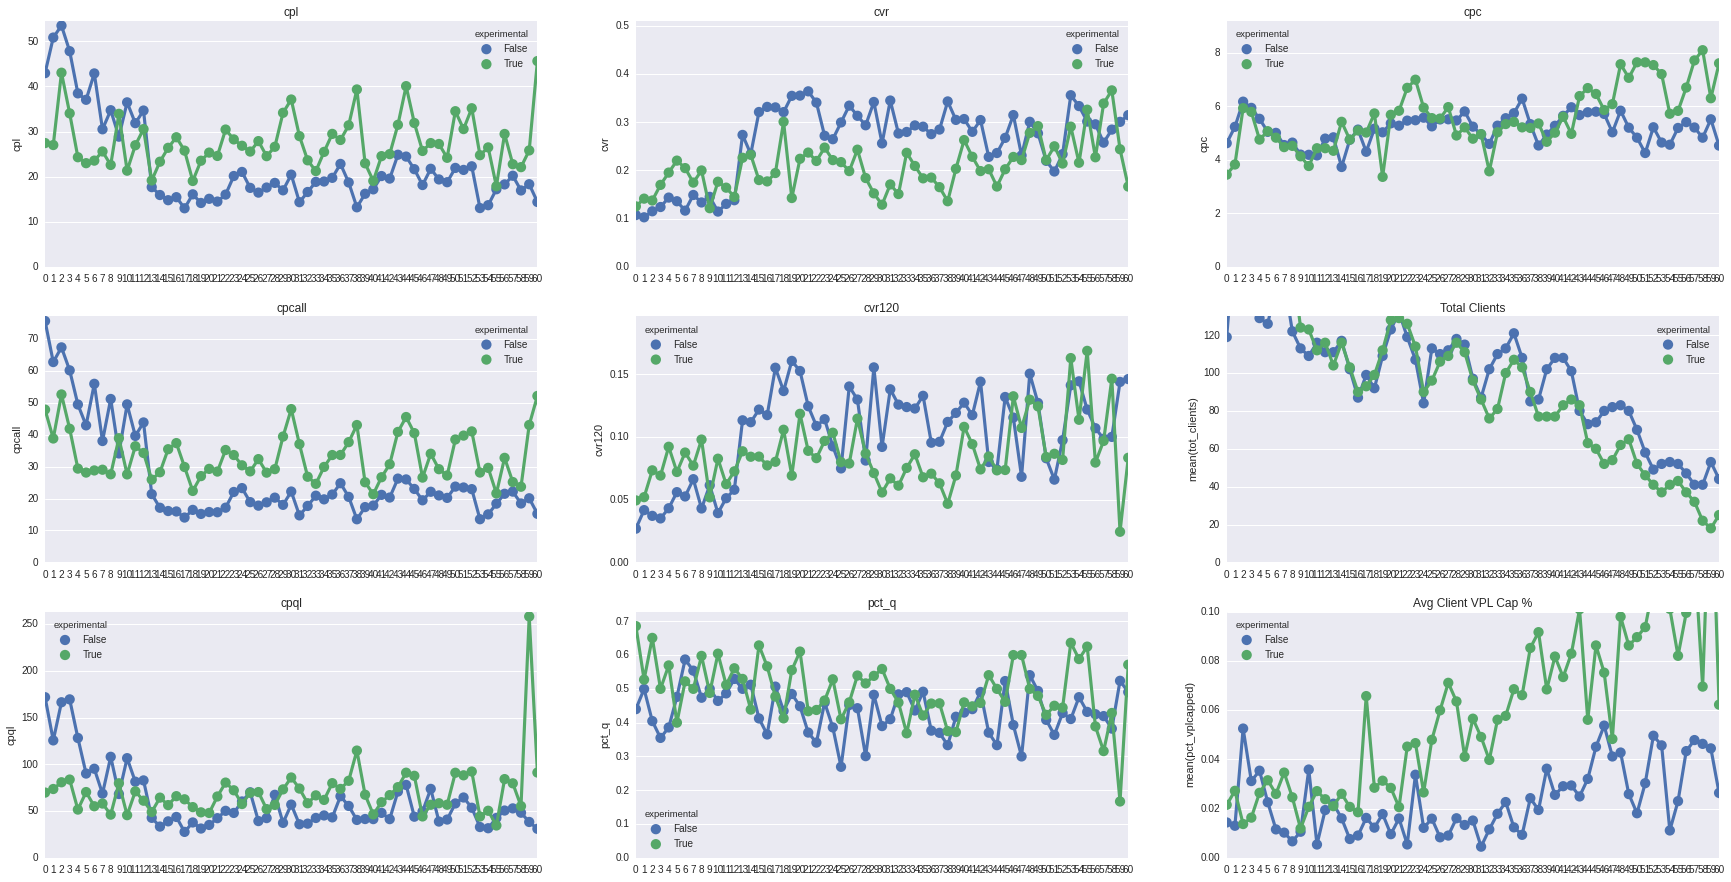

In [11]:
a = df.groupby(['days_out', 'experimental'], as_index=False)[in_metrics].sum()

for k, v in out_metrics.items():
    a[k] = a[v[0]] / a[v[1]]

%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

fig, axs = plt.subplots(3, 3, figsize=(30, 15))

dPlot = {'cpl': axs[0,0], 'cpcall': axs[1,0], 'cpql': axs[2,0], 'cvr': axs[0,1], 'cvr120': axs[1,1], 'pct_q': axs[2,1], 'cpc': axs[0,2]}

for k, v in dPlot.items():
    sns.pointplot('days_out', k, hue='experimental', data=a, ax=v)
    v.set_ylim([0, max([i for i in a[k] if str(i)!='inf'])*1.02])
    v.set_xlim(0, 60)
    v.set_ylabel(k)
    v.set_xlabel('')
    v.set_title(k)

sns.pointplot('days_out', 'tot_clients', hue='experimental', data = df.groupby(['days_out', 'experimental'], as_index=False)['client_id'].agg({'tot_clients': lambda x: x.nunique()}), ax=axs[1,-1])    
axs[1,-1].set_title('Total Clients')
axs[1,-1].set_ylim(0, 130)
axs[1,-1].set_xlim(0, 60)
axs[1,-1].set_xlabel('')

sns.pointplot('days_out', 'pct_vplcapped', hue='experimental', data = df.groupby(['days_out', 'experimental'], as_index=False)['pct_vplcapped'].mean(), ax=axs[-1,-1])
axs[-1,-1].set_title('Avg Client VPL Cap %')
axs[-1,-1].set_ylim(0, .1)
axs[-1,-1].set_xlim(0, 60)
axs[-1,-1].set_xlabel('')
    
plt.show()

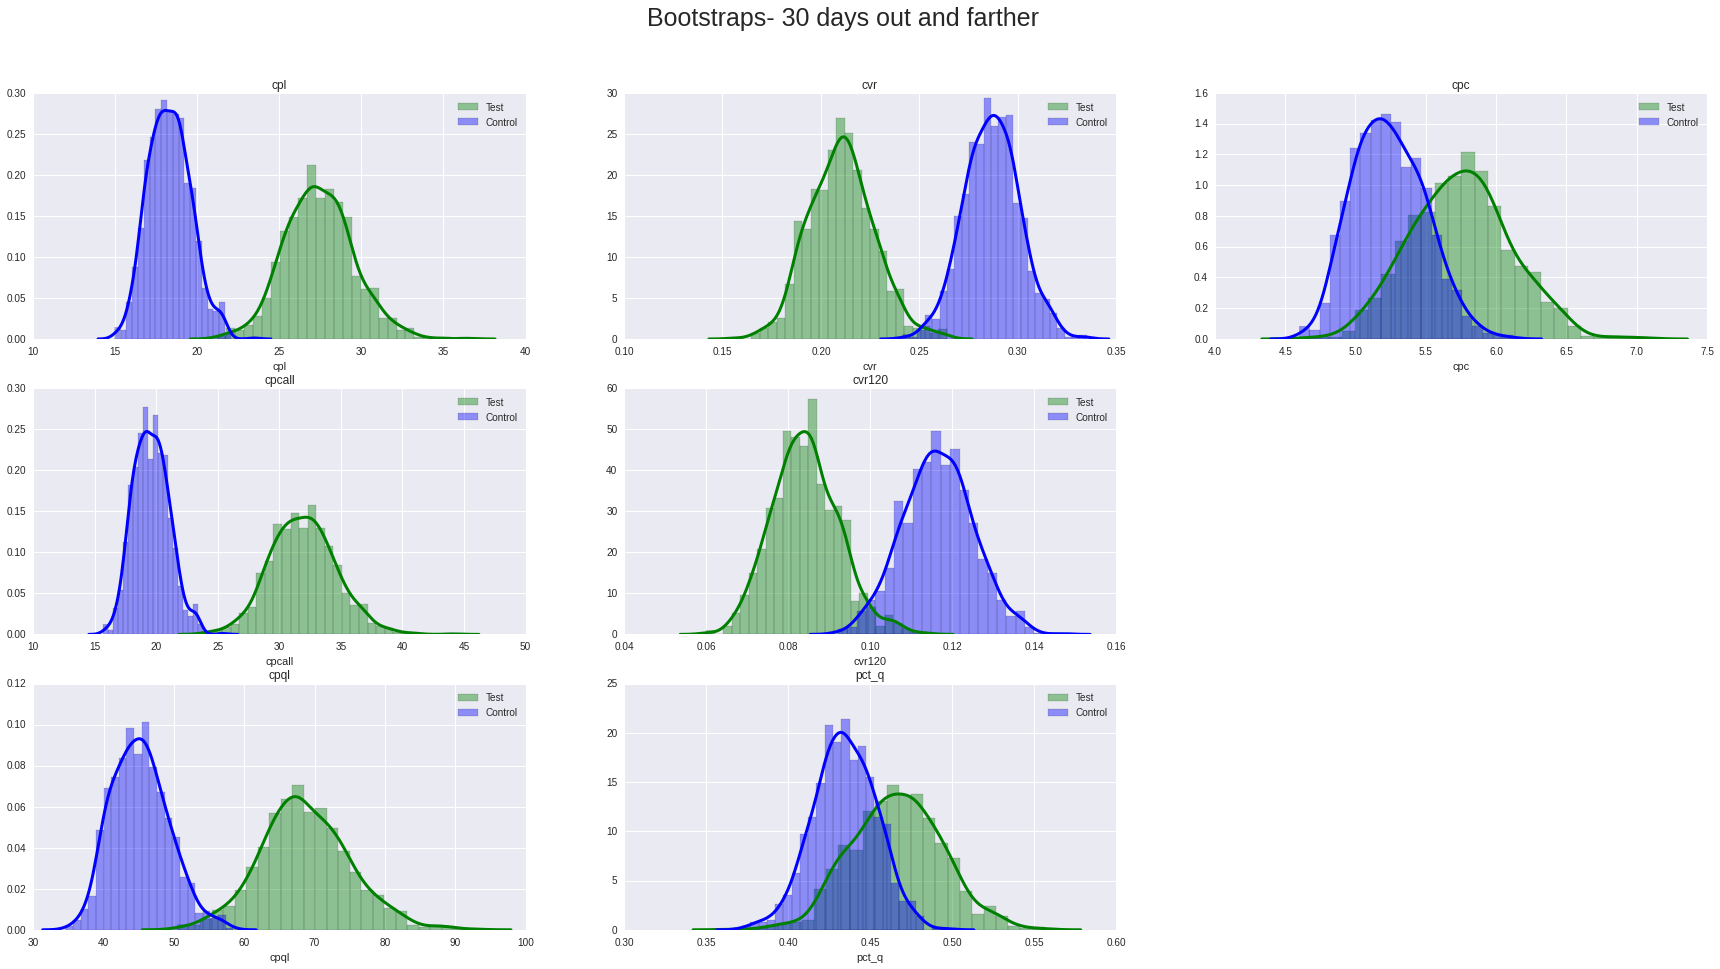

In [12]:
sns.set_style('darkgrid')

TEST_ACFS = list(set(df[df.experimental==True].adconfiguration_id))
CONTROL_ACFS = list(set([i for i in df.adconfiguration_id if i not in TEST_ACFS]))

test_bs, control_bs = get_bootstraps(1000)

fig, axs = plt.subplots(3, 3, figsize=(30, 15))
fig.suptitle('Bootstraps- 30 days out and farther', fontsize=25)

dPlot = {'cpl': axs[0,0], 'cpcall': axs[1,0], 'cpql': axs[2,0], 'cvr': axs[0,1], 'cvr120': axs[1,1], 'pct_q': axs[2,1], 'cpc': axs[0,2]}

for k, v in dPlot.items():
    sns.distplot(test_bs[k], kde_kws={'lw': 3}, ax=v, color='green', label='Test')
    sns.distplot(control_bs[k], kde_kws={'lw': 3}, ax=v, color='blue', label='Control')
    v.set_title(k)
    v.legend(loc='upper right')
    
fig.delaxes(axs[1,-1])
fig.delaxes(axs[2,-1])

In [ ]:
get_top_kps(df_clients)

In [1]:
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english') + stopwords.words('spanish')

in_metrics = ['clicks', 'cost', 'calls', 'calls120', 'leads']
out_metrics = {'cpc': ('cost', 'clicks'), 'cpl': ('cost', 'leads'),'cpcall': ('cost', 'calls'), 
               'cpql': ('cost', 'calls120'), 'cvr': ('leads', 'clicks'), 'cvr120': ('calls120', 'clicks'), 
               'pct_q': ('calls120', 'calls')}

def get_alllawyers():
    #gets lawyers launched after 4/12, keeps only those whose bc createddate and livedate are both after 4/12
    df_clients = core('''
                    select distinct a.client_id, cbc.createddate::date
                    from analytics.client_static_basic a
                     join control.client_product_milestonedates mile on a.client_id = mile.client_id
                      and mile.product_id = (select id from control.product where name = 'SEM')
                      and mile.livedate>='2016-04-12'
                      and a.segment_name = 'Lawyer'
                      and a.client_type = 'Local'
                     join control.campaignconfiguration ccc on a.adconfiguration_id = ccc.adconfiguration_id
                     join control.basecampaign cbc on cbc.campaignconfiguration_id = ccc.id
                    ''')
    df_clients['after_change'] = [1 if x >= dt.date(2016, 4, 12) else 0 for x in df_clients.createddate]
    df_clients['dummy'] = 1
    
    return tuple(df_clients.groupby('client_id').filter(lambda x: sum(x.after_change)==sum(x.dummy)).client_id.drop_duplicates().tolist())


def filter_othersegs(CIDS):
    #get clients broad match taxonomy, plusses all stop words, seperates keywords that are not fully bmm-ed and prints their segments
    df_tax = core('''
                select distinct a.client_id, csc.id as sc_id, csc.name as servicecategory, csc.segment_id, cbc.campaigntype, cbc.target, k.phrase, l.matchtype
                from analytics.client_static_basic a
                 join control.campaignconfiguration ccc on a.adconfiguration_id = ccc.adconfiguration_id
                  and a.client_id in {param_cids}
                 join control.servicecategory csc on ccc.servicecategory_id = csc.id
                 join control.basecampaign cbc on cbc.campaignconfiguration_id = ccc.id
                 join control.listing l on cbc.id = l.campaign_id
                  and l.matchtype in (1, 6)
                 join control.keyphrase k on l.keyphraseid = k.id
                '''.format(param_cids = tuple(CIDS)))

    CIDS = [i for i in CIDS if i not in df_tax[df_tax.segment_id!=43440].client_id.drop_duplicates().tolist()]
    
    return CIDS


def get_test(CIDS):
    #Get test clients first day of impressions, keep only those that got impressions
    df_test = core('''
                    select a.client_id, adconfiguration_id, mile.firstdayofimpressions
                    from analytics.client_static_basic a
                     join control.milestonedates mile on a.client_id = mile.client_id
                      and a.client_id in {param_cids}
                      and mile.firstdayofimpressions is not null
                    order by firstdayofimpressions
                    '''.format(param_cids = tuple(CIDS)))
    df_test['experimental'] = True
    drange = (max(df_test.firstdayofimpressions) - min(df_test.firstdayofimpressions)).days
    start = "'"+str(dt.date(2016, 4, 10) - dt.timedelta(days = drange))+"'"
    end = "'"+str(dt.date(2016, 4, 10))+"'"

    return df_test, start, end
            

def get_control(start, end):
    #Get control clients, lawyers launched within same window, 28 days prior, strip out any with taxonomy from other segments
    df_control = core('''
                    select a.client_id, a.adconfiguration_id, mile.firstdayofimpressions
                    from analytics.client_static_basic a
                     join control.milestonedates mile on a.client_id = mile.client_id
                      and mile.firstdayofimpressions::text >= {param_start}
                      and mile.firstdayofimpressions::text <= {param_end}
                      and a.segment_name = 'Lawyer'
                      and a.client_type = 'Local'
                    order by client_id asc
                    '''.format(param_start = start, param_end = end))
    control_tax = core('''
                    select distinct a.client_id, csc.id as sc_id, csc.name as servicecategory, csc.segment_id, cbc.campaigntype, cbc.target, k.phrase, l.matchtype
                    from analytics.client_static_basic a
                     join control.campaignconfiguration ccc on a.adconfiguration_id = ccc.adconfiguration_id
                      and a.client_id in {param_cids}
                     join control.servicecategory csc on ccc.servicecategory_id = csc.id
                     join control.basecampaign cbc on cbc.campaignconfiguration_id = ccc.id
                     join control.listing l on cbc.id = l.campaign_id
                      and l.matchtype in (1, 6)
                     join control.keyphrase k on l.keyphraseid = k.id
                    '''.format(param_cids = tuple(set(df_control.client_id))))
    df_control = df_control[~df_control.client_id.isin(control_tax[control_tax.segment_id!=43440].client_id.tolist())]
    df_control['experimental'] = False
    
    return df_control


def fill_vpl(x, d):
    if np.isnan(x.pct_vplcapped):
        if np.isnan(d[x.adconfiguration_id]): 
            return 0
        else: 
            return d[x.adconfiguration_id]
    else:
        return x.pct_vplcapped

    
def get_data(df_clients):
    df_data = algo('''
                select map.adconfiguration_id
                       ,(case when map.provider_id = 1 then 'Google_DT' 
                              when map.provider_id = 4 then 'MSN' 
                              when map.provider_id = 18 then 'Google_M' else '' end) as provider
                       ,(case when map.target = 0 then 'Geo' else 'Term' end) as target
                       ,agg.day
                       ,sum(agg.clicks) as clicks
                       ,sum(agg.call) as calls
                       ,sum(agg.call60) as calls60
                       ,sum(agg.call120) as calls120
                       ,sum(agg.leads) as leads
                       ,sum(agg.cost) as cost
                       ,sum(agg.bidfull_cost) as bidfull_cost
                       ,lb.vpl_imprest as pct_vplcapped
                from control.listingidmap map 
                 join aggregates.listing_day agg on map.listingid = agg.listing_id
                  and map.adconfiguration_id in {param_acfids}
                  and agg.day >= '2016-2-16'
                  and map.provider_id in (1, 4, 18)
                  and map.target in (0, 1)
                 left join control.listings_bid lb on map.adconfiguration_id = lb.adconfiguration_id and agg.day = lb.day
                group by map.adconfiguration_id, map.provider_id, map.target, agg.day, lb.vpl_imprest
            '''.format(param_acfids = tuple(set(df_clients.adconfiguration_id))))
    df = pd.merge(df_data, df_clients, on='adconfiguration_id')
    f = lambda x: (x.day - x.firstdayofimpressions).days
    df['days_out'] = df.apply(f, axis=1)
    
    vpl_d = df.groupby('adconfiguration_id').pct_vplcapped.mean().to_dict()

    df['pct_vplcapped'] = df.apply(fill_vpl, args=(vpl_d,), axis=1)
    df['pct_vplcapped'] = df.pct_vplcapped.fillna(0)
    
    return df  


def get_top_kps(df_clients):
    df_top_kps = core('''
                    select clientid as client_id, keyphrase, matchtype, sum(impressions) as imps
                    from control.provider_reports pr
                    where clientid in {param_cids}
                     and day>='2016-02-16'
                    group by clientid, keyphrase, matchtype
                    '''.format(param_cids = tuple(set(df_clients.client_id))))
    df_top_kps = pd.merge(df_top_kps, df_clients, on='client_id')
    a = df_top_kps.groupby(['experimental', 'keyphrase', 'matchtype'], as_index=False).imps.sum().sort_values(['experimental', 'imps'], ascending=False)
    
    return a.groupby('experimental').head(10)


def random_sample(l):
    return list(np.random.choice(l, len(l), replace=True))

def bootstrap(clients, df):
    rs = random_sample(clients)
    out = pd.DataFrame(columns=df.columns)
    for c in rs:
        out = out.append(df[df.adconfiguration_id==c])
    out = pd.DataFrame(out[in_metrics].sum())
    for k, v in out_metrics.items():
        out.loc[k] = out.loc[v[0]] / out.loc[v[1]]

    return out.T

def get_bootstraps(n):
    test_bs = pd.DataFrame()
    control_bs = pd.DataFrame()
    i=0
    while i<n:
        test_bs = test_bs.append(bootstrap(TEST_ACFS, df[df.days_out>=30]))
        i+=1
    i=0
    while i<n:
        control_bs = control_bs.append(bootstrap(CONTROL_ACFS, df[df.days_out>=30]))
        i+=1
        
    return test_bs, control_bs  